# Journal Profiling Part 3: Funding

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [grants data ](https://docs.dimensions.ai/dsl/datasource-grants.html) for a list of researchers, so to enrich this list with funding-related metrics. 

This tutorial is the third of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the researchers impact metrics dataset previously extracted
* Query the grants API using the researchers IDs, to obtain their total grants and funding amount
* Enrich the original dataset with these new metrics  
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.shortcuts import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')    
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.4.2)
Connected to: https://app.dimensions.ai - DSL v1.27
Method: dsl.ini file


Finally, let's set up a folder to store the data we are going to extract: 

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)

def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

### Load previously saved researchers data 

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `2_researchers_impact_metrics.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [3]:
researchers = pd.read_csv(FOLDER_NAME+"/2_researchers_impact_metrics.csv")

In [4]:
# TIP to speed this up I'm taking only the top 2000 researchers!
# for a full analysis, just comment out the next line
researchers = researchers[:2000]

In [5]:
# note the extra column will be dropped after re-running
researchers.head(5)

researcher_id  pubs               full_name  citations_mean  \
0   ur.0723426172.10    63         Kari Stefansson      129.555556   
1  ur.01277776417.51    45  Unnur Thorsteinsdottir       93.088889   
2   ur.0641525362.39    35      Gonçalo R Abecasis      134.257143   
3  ur.01247426430.47    33     Gudmar Thorleifsson       94.121212   
4  ur.01317433110.75    33        Caroline Hayward      157.333333   

   altmetric_mean  last_pub_year  \
0      229.603175           2020   
1      160.622222           2019   
2      138.514286           2020   
3      171.878788           2019   
4      296.212121           2020   

                                                 url  
0  https://app.dimensions.ai/discover/publication...  
1  https://app.dimensions.ai/discover/publication...  
2  https://app.dimensions.ai/discover/publication...  
3  https://app.dimensions.ai/discover/publication...  
4  https://app.dimensions.ai/discover/publication...

## Adding another impact measure: funding 

We want to enhance the reseachers dataset by adding some funding information:

* total amount of funding for each researcher 
* total number of grants 
* funding end date (useful to understand who is going to publish soon)

### We'll have to do it in two steps


**1 Total grants and last grants year can be easy to extract using the 'researchers' source.** For example:

In [6]:
%%dsldf  
search researchers 
    where id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id+last_grant_year+total_grants]

Returned Researchers: 2 (total = 2)
Time: 0.78s


id  total_grants  last_grant_year
0  ur.01277776417.51             0              NaN
1   ur.0723426172.10             8           2018.0

**2 Aggregated funding needs to be extracted from the `grants` database.** For example:

> NOTE this kind of aggregate query will not return any data if a researcher that has no grants!


In [7]:
%%dsldf 
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 13
Time: 0.62s


id  count     funding
0     ur.0723426172.10      8  17760368.0
1   ur.012662217132.90      2         0.0
2   ur.010520247252.54      1         0.0
3    ur.01121653260.31      1         0.0
4    ur.01127672147.84      1         0.0
5   ur.011316554452.18      1         0.0
6   ur.012167132327.75      1         0.0
7   ur.012237141052.77      1         0.0
8   ur.012455520474.57      1         0.0
9    ur.01274135317.46      1   2592940.0
10  ur.013362317204.29      1         0.0
11  ur.016620004052.08      1         0.0
12     ur.057767065.52      1         0.0

## Next: full data for step 1

What we're gonna do 

1. loop over all researchers (400 at a time) 
2. extract the **tot grants** and **last grants year** information
3. collect all data into a single dataframe 
4. finally, add the data to our 'researchers' spreadsheet 



In [8]:
llist = list(researchers['researcher_id'])
VERBOSE = False
#
#
query = """search researchers 
                where id in {} 
            return researchers[id+last_grant_year+total_grants] limit 1000"""
#
#
out = []
for chunk in progress(list(chunks_of(list(llist), 400))):
    q = dsl.query(query.format(json.dumps(chunk)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df1 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df1))


Researchers used to query:  2000
Researchers returned:  2000


Save the data so that we can use it later, and preview the results.

In [9]:
df1.head(10)

total_grants                 id  last_grant_year
0             0  ur.01004460445.52              NaN
1             0  ur.01201444625.22              NaN
2             0  ur.01307114140.50              NaN
3             0  ur.01063107667.97              NaN
4             0  ur.01155553465.69              NaN
5             0   ur.0575702706.33              NaN
6             1  ur.01217411134.93           2022.0
7             0   ur.0675136436.15              NaN
8             1  ur.01324147461.28           2023.0
9             0  ur.01116254763.53              NaN

## Next: full data for step 2

For this part we will do the following steps:

1. loop over all researchers, chunked in groups of 50
2. for each group, query grants matching those researchers IDs. Instead of returning grants data though, we **facet** on researchers and **aggregate funding information**
3. process the researchers data we got, so to keep only the journal authors we are interested in

**NOTE** since we are querying for grants, each query can return many more researchers than the ones we are asking for, as the co-authors of a grant are also matched

Example query:

In [10]:
%%dsldf  
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 13
Time: 0.72s


id  count     funding
0     ur.0723426172.10      8  17760368.0
1   ur.012662217132.90      2         0.0
2   ur.010520247252.54      1         0.0
3    ur.01121653260.31      1         0.0
4    ur.01127672147.84      1         0.0
5   ur.011316554452.18      1         0.0
6   ur.012167132327.75      1         0.0
7   ur.012237141052.77      1         0.0
8   ur.012455520474.57      1         0.0
9    ur.01274135317.46      1   2592940.0
10  ur.013362317204.29      1         0.0
11  ur.016620004052.08      1         0.0
12     ur.057767065.52      1         0.0

Here we 'chunk' using a lower number because each query will return more researchers than the ones we ask for (because we are querying 'grants' this time) 

In [11]:
llist = list(researchers['researcher_id'])
VERBOSE = False

#
#
query = """search grants 
            where researchers.id in {} 
           return researchers[id] aggregate funding limit 1000"""
#
#
out = []
for batch in progress(list(chunks_of(llist, 50))):
    q = dsl.query(query.format(json.dumps(batch)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df2 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df2))


Researchers used to query:  2000
Researchers returned:  37377


Save to csv and preview the data

In [12]:
df2.head(10)

id  count      funding
0  ur.011026120037.74     41  123520876.0
1  ur.015704744537.99     38   26811091.0
2  ur.013723776517.34     35  116511589.0
3  ur.016704245502.43     33   56868166.0
4   ur.01367711150.31     32   74378595.0
5   ur.01313145634.66     29   15473267.0
6  ur.010065171457.69     27   18617422.0
7   ur.01104262534.26     23  175536074.0
8    ur.0763727005.09     23   92880421.0
9   ur.01267360065.55     18   22934179.0

## Finally: let's merge the new data into the 'researchers-impact' table

In [13]:
#
# first let's replace all empty values with zeros
#

df1 = df1.fillna(0)
df2 = df2.fillna(0)

#
# helper functions 
#

def grants_and_year_from_id(researcher_id):
  "try/except to prevent some parsing errors."
  try:
    x = int(df1[df1['id'] == researcher_id]['total_grants'])
  except:
    x = 0
  try:
    y = int(df1[df1['id'] == researcher_id]['last_grant_year'])
  except:
    y = 0
  return (x, y)

def total_funding_from_id(researcher_id):
    """Since the bulk querying returned several rows for same researcher (due to various random combinations
    of researcher IDs lists in the query filters), we take the max value."""
    return df2[df2['id'] == researcher_id]['funding'].max()
    
#
# merge the results found into original researchers dataset
#

total_grants, last_grant_year, total_funding  = [], [], []

for i, row in progress(researchers.iterrows(), total=researchers.shape[0]):
    res_id = row['researcher_id']
    data = grants_and_year_from_id(res_id)
    total_grants.append(data[0])
    last_grant_year.append(data[1])
    total_funding.append(total_funding_from_id(res_id))

researchers['total_grants'] = total_grants
researchers['last_grant_year'] = last_grant_year
researchers['total_funding'] = total_funding
#
# finally..
#
print("=======\nResearchers total:",  len(researchers))
researchers.head(10)


Researchers total: 2000


researcher_id  pubs               full_name  citations_mean  \
0    ur.0723426172.10    63         Kari Stefansson      129.555556   
1   ur.01277776417.51    45  Unnur Thorsteinsdottir       93.088889   
2    ur.0641525362.39    35      Gonçalo R Abecasis      134.257143   
3   ur.01247426430.47    33     Gudmar Thorleifsson       94.121212   
4   ur.01317433110.75    33        Caroline Hayward      157.333333   
5   ur.01313145634.66    32         Andres Metspalu      202.000000   
6   ur.01264737414.70    31               Tõnu Esko      177.000000   
7  ur.014377465057.81    30       Benjamin M. Neale      271.900000   
8    ur.0637651205.48    29   Daniel F Gudbjartsson       85.448276   
9   ur.01174076626.46    28   André G. Uitterlinden      117.107143   

   altmetric_mean  last_pub_year  \
0      229.603175           2020   
1      160.622222           2019   
2      138.514286           2020   
3      171.878788           2019   
4      296.212121           2020   
5      369.281250           2019   
6      384.548387           2020   
7      169.233333           2020   
8      149.689655           2019   
9      298.535714           2019   

                                                 url  total_grants  \
0  https://app.dimensions.ai/discover/publication...             8   
1  https://app.dimensions.ai/discover/publication...             0   
2  https://app.dimensions.ai/discover/publication...            12   
3  https://app.dimensions.ai/discover/publication...             0   
4  https://app.dimensions.ai/discover/publication...             3   
5  https://app.dimensions.ai/discover/publication...            30   
6  https://app.dimensions.ai/discover/publication...             9   
7  https://app.dimensions.ai/discover/publication...             7   
8  https://app.dimensions.ai/discover/publication...             0   
9  https://app.dimensions.ai/discover/publication...             1   

   last_grant_year  total_funding  
0             2018     17760368.0  
1                0            NaN  
2             2023     61439889.0  
3                0            NaN  
4             2024      5341499.0  
5             2022     15473267.0  
6             2021      1605780.0  
7             2023     50128910.0  
8                0            NaN  
9             2014            0.0

Save the data / download it

In [14]:
save(researchers, "3_researchers_impact_metrics_and_funding.csv")

## Couple of Dataviz

In [15]:
temp1 = researchers.sort_values(by=["total_funding"], ascending=False)[:100]
temp2 = researchers.sort_values(by=["last_grant_year"], ascending=False)[:200]

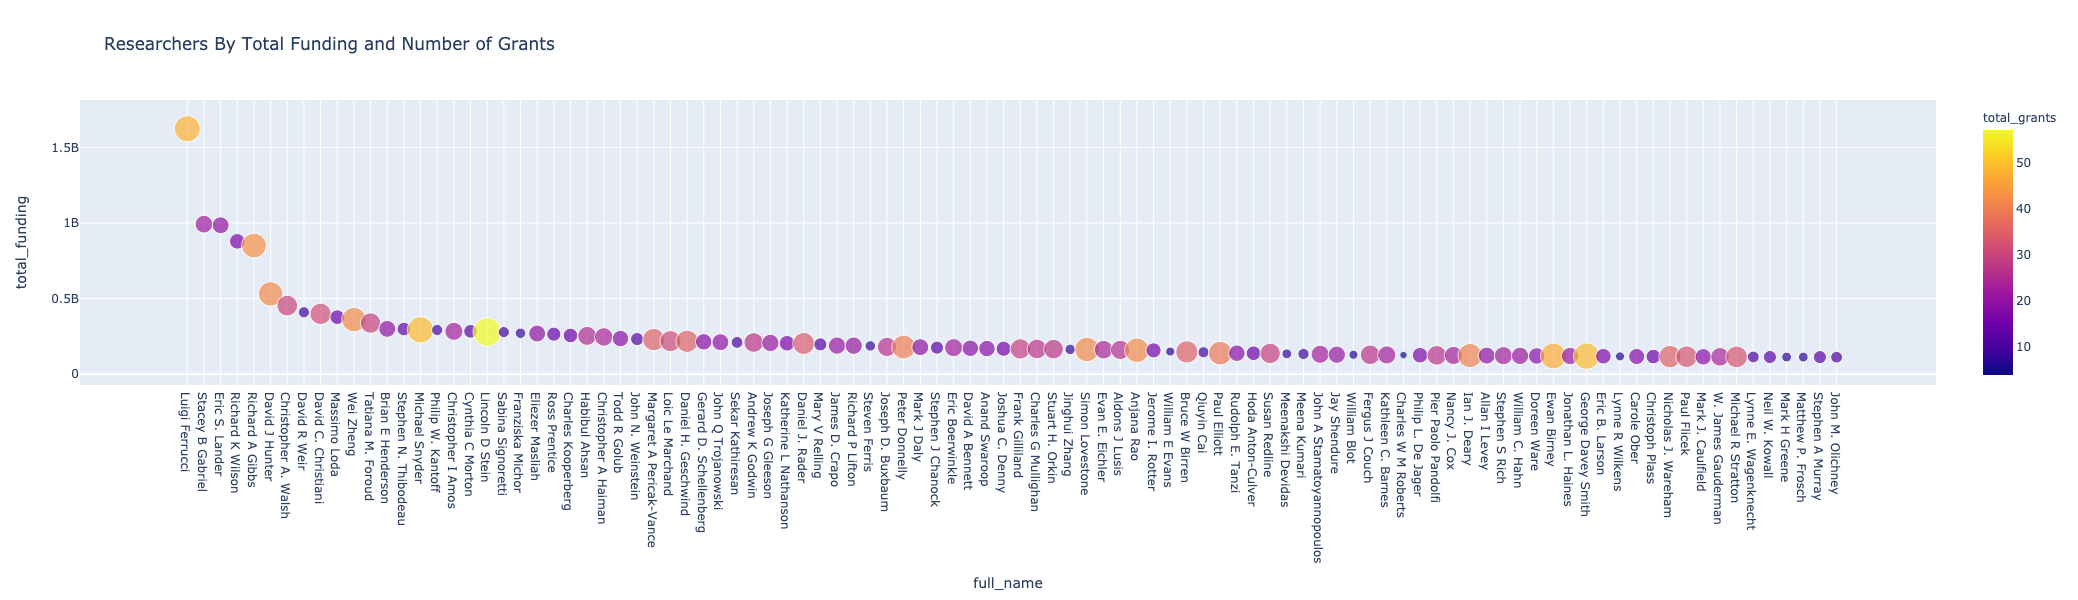

In [20]:
px.scatter(temp1, 
           x="full_name", y="total_funding", 
           hover_name="full_name", 
           size="total_grants", 
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           height=600,
           title="Researchers By Total Funding and Number of Grants")

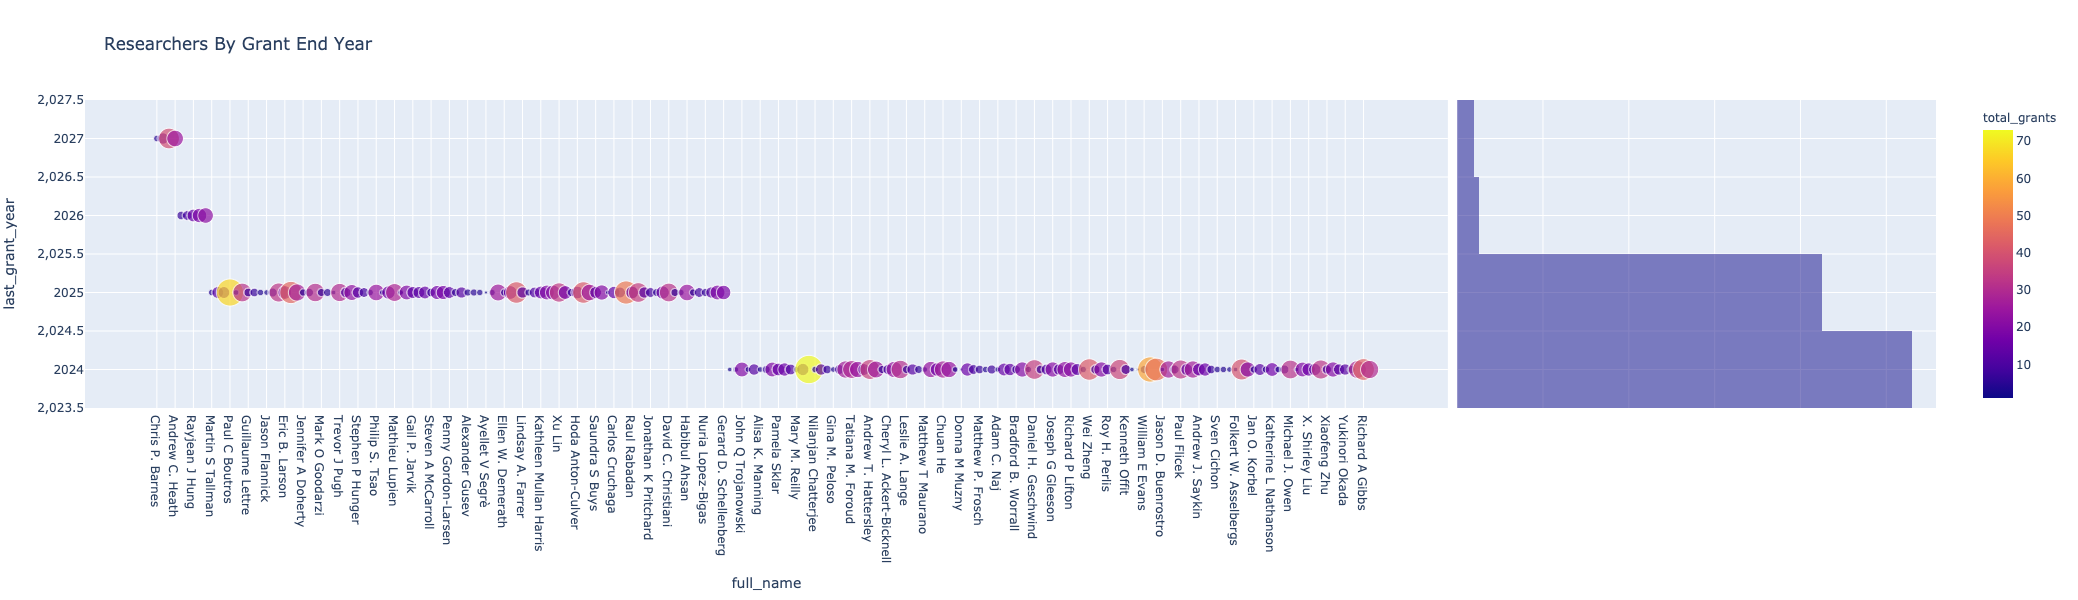

In [21]:
px.scatter(temp2, 
           x="full_name", y="last_grant_year", 
           hover_name="full_name", 
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           height=600,
           marginal_y="histogram",  title="Researchers By Grant End Year")

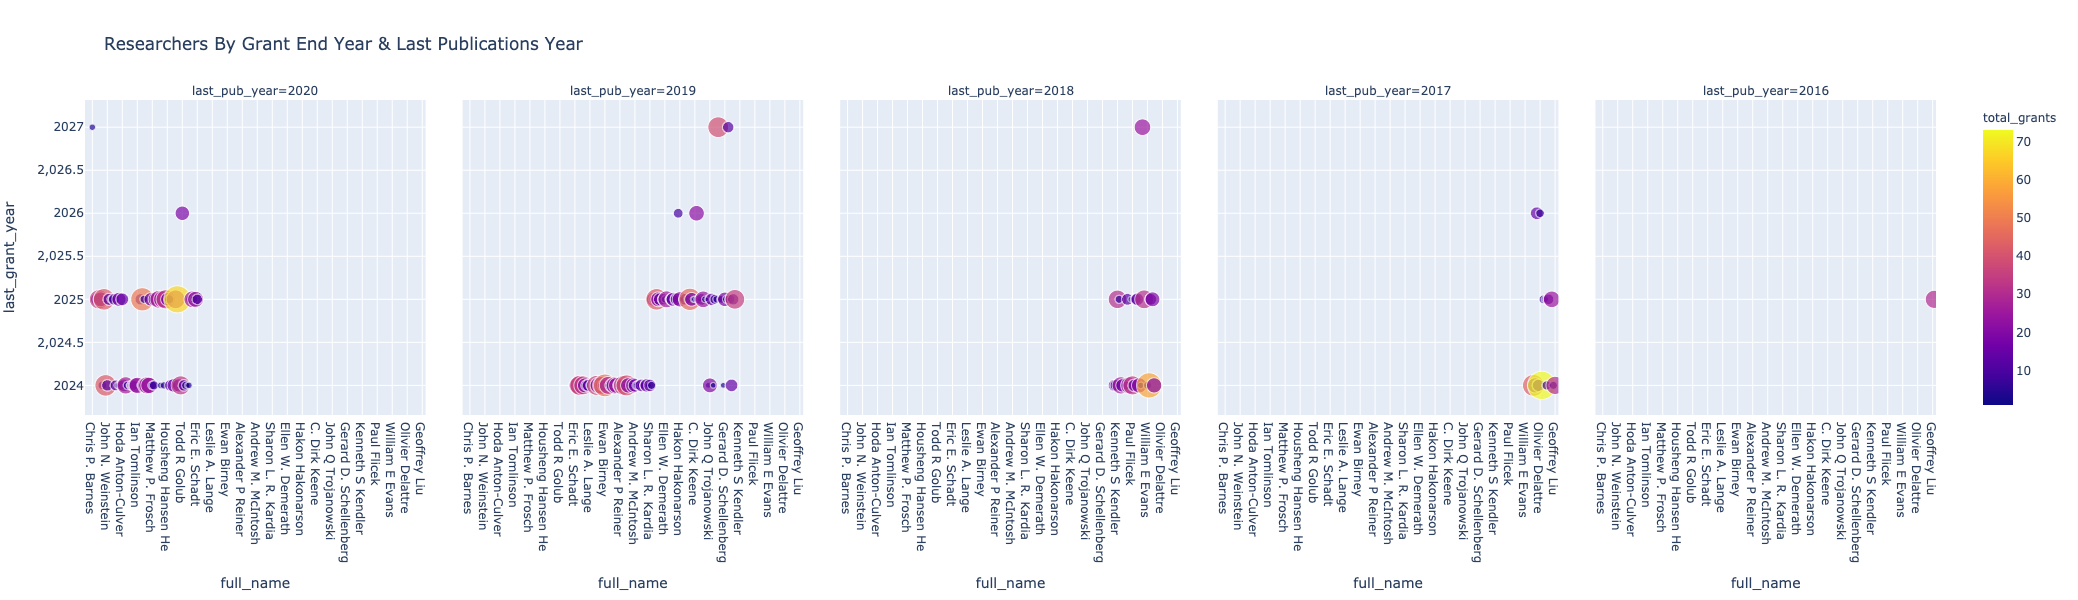

In [22]:
px.scatter(temp2.sort_values("last_pub_year", ascending=False), 
           x="full_name", y="last_grant_year", 
           hover_name="full_name",  
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           facet_col="last_pub_year", 
           height=600,
           title="Researchers By Grant End Year & Last Publications Year")

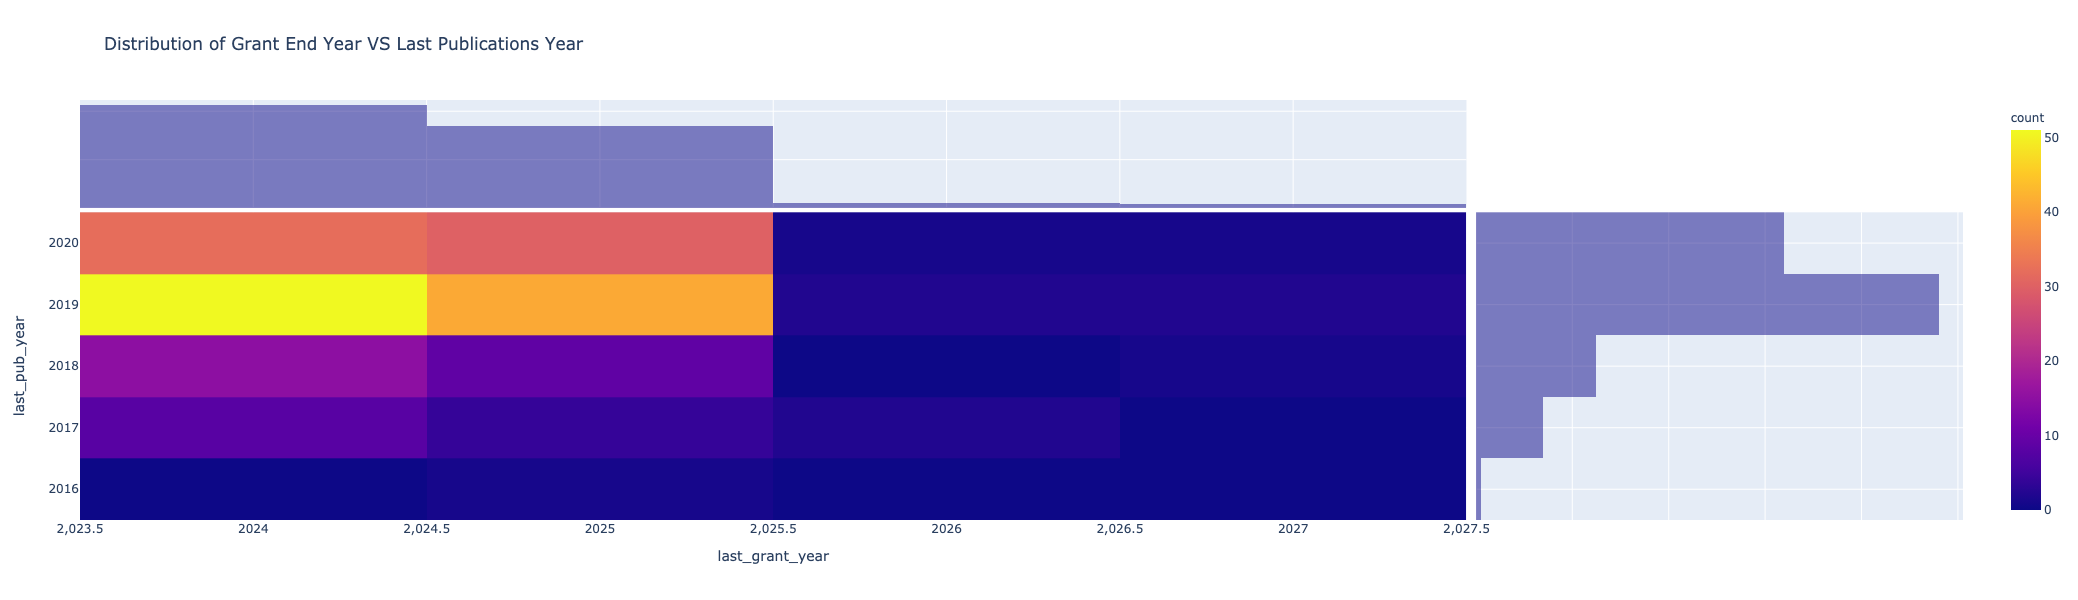

In [23]:
px.density_heatmap(temp2, 
                   x="last_grant_year", y="last_pub_year", 
                   marginal_x="histogram", marginal_y="histogram", 
                   height=600,
                   title="Distribution of Grant End Year VS Last Publications Year")